# Mango Leaf Disease Detection

This notebook implements a deep learning classifier to detect various mango leaf diseases using transfer learning with pre-trained models.

## 1. Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, MobileNetV2, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

d:\Projects\mango-leaf-classifer\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\Projects\mango-leaf-classifer\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
d:\Projects\mango-leaf-classifer\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode

## 2. Configure Parameters

In [2]:
# Configuration parameters
IMG_SIZE = 224  # Standard input size for most pre-trained models
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Paths
DATA_DIR = "data/images"
OUTPUT_DIR = "data/output"
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Get class names (disease types) from directory names
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
NUM_CLASSES = len(class_names)

print(f"Total {NUM_CLASSES} classes: {class_names}")

Total 8 classes: ['1_ Anthracnose', '2_Bacterial_Canker', '3_Cutting_Weevil', '4_Die_Back', '5_Gall_Midge', '6_Powdery_Mildew', '7_Sooty_Mould', '8_Healthy']


## 3. Data Preprocessing and Augmentation

In [3]:
# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create train generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
validation_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
print("------------------")
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
------------------
Number of training samples: 3200
Number of validation samples: 800


## 4. Model Creation (Using chosen model)

In [15]:
def create_model(base_model_name='mobilenetv2'):
    if base_model_name.lower() == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    elif base_model_name.lower() == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    elif base_model_name.lower() == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    elif base_model_name.lower() == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    else:
        raise ValueError("Unsupported model name")
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and display model summary "mobilenetv2" "vgg16" "vgg19" "resnet50", 
MODEL_NAME = 'vgg19'
model = create_model(MODEL_NAME)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,078,600 (80.41 MB)

 Trainable params: 1,054,216 (4.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

## 5. Model Training

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

# Save the model with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join(MODEL_DIR, f'model_{MODEL_NAME}_{timestamp}.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

Epoch 1/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 8:56 5s/step - accuracy: 0.2188 - loss: 2.0994

## 6. Evaluate Model Performance

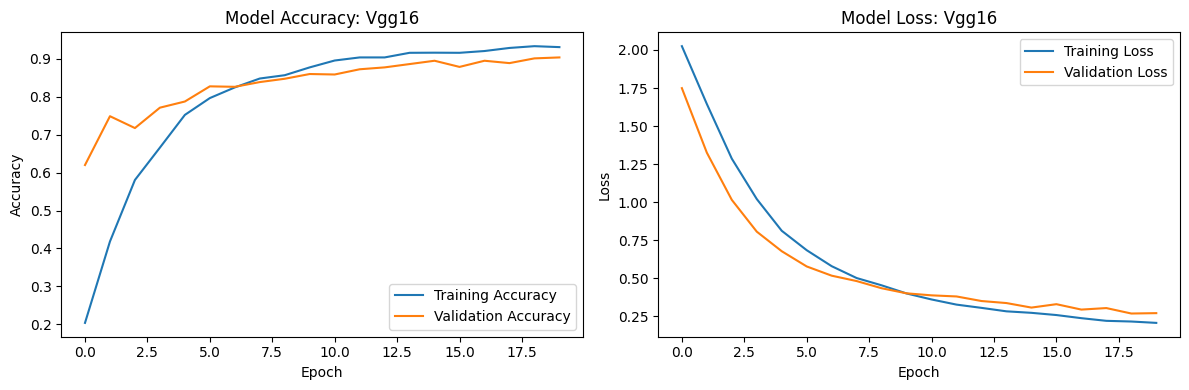

25/25 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step


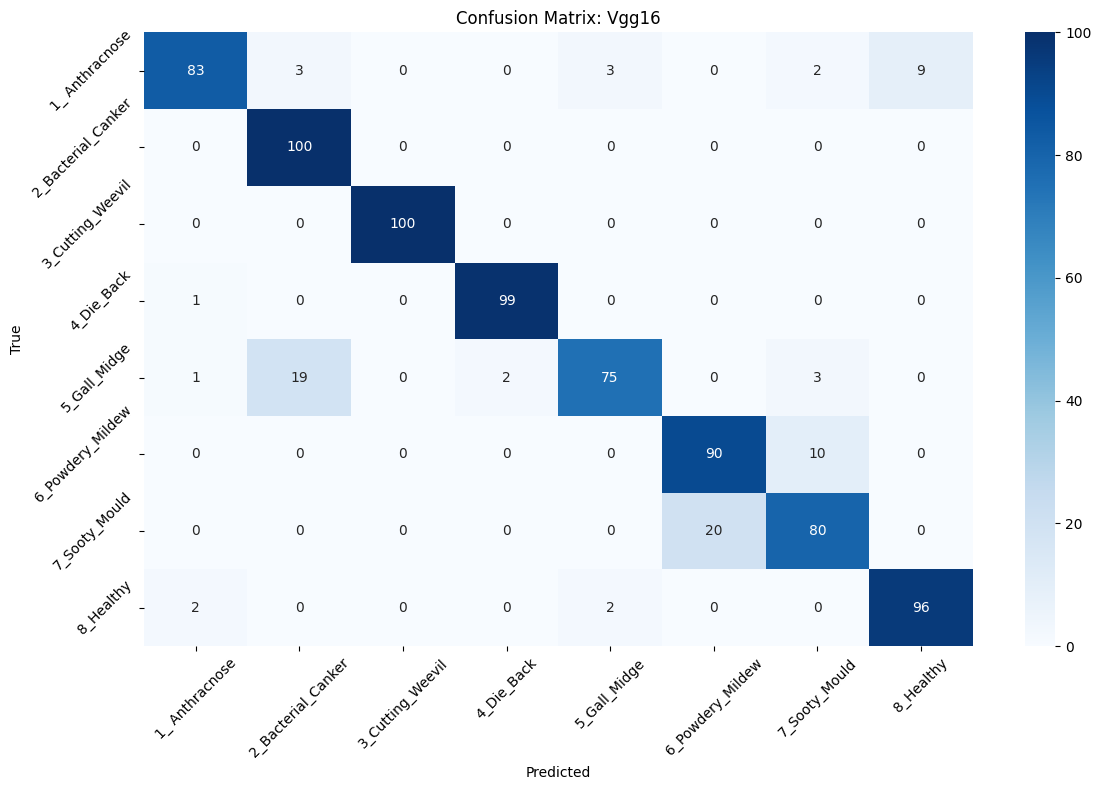


Classification Report: Vgg16
                    precision    recall  f1-score   support

    1_ Anthracnose       0.95      0.83      0.89       100
2_Bacterial_Canker       0.82      1.00      0.90       100
  3_Cutting_Weevil       1.00      1.00      1.00       100
        4_Die_Back       0.98      0.99      0.99       100
      5_Gall_Midge       0.94      0.75      0.83       100
  6_Powdery_Mildew       0.82      0.90      0.86       100
     7_Sooty_Mould       0.84      0.80      0.82       100
         8_Healthy       0.91      0.96      0.94       100

          accuracy                           0.90       800
         macro avg       0.91      0.90      0.90       800
      weighted avg       0.91      0.90      0.90       800



In [10]:

# Create subdirectory for model name if it doesn't exist
MODEL_OUTPUT_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Model Accuracy: {MODEL_NAME.capitalize()}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss: {MODEL_NAME.capitalize()}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(os.path.join(OUTPUT_DIR, MODEL_NAME), f'training_history_{timestamp}.png'))
plt.show()

# Get predictions for confusion matrix
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix: {MODEL_NAME.capitalize()}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
# save to subdirectory of model name
plt.savefig(os.path.join(os.path.join(OUTPUT_DIR, MODEL_NAME), f'confusion_matrix_{timestamp}.png'))
plt.show()

# Print classification report
print(f"\nClassification Report: {MODEL_NAME.capitalize()}")
print(classification_report(y_true, y_pred, target_names=class_names))

## 7. Model Prediction Function

In [14]:
def predict_disease(image_path, model):
    """
    Predict disease for a single image
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    return {
        'disease': class_names[predicted_class],
        'confidence': float(confidence),
        'probabilities': {class_names[i]: float(p) for i, p in enumerate(prediction[0])}
    }

# Example usage of prediction function
# Replace with actual image path for testing
test_image_path = "data/images/1_ Anthracnose/20211008_124249 (Custom).jpg"
if os.path.exists(test_image_path):
    result = predict_disease(test_image_path, model)
    print("\nPrediction Result:")
    print(f"Predicted Disease: {result['disease']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print("\nAll probabilities:")
    for disease, prob in result['probabilities'].items():
        print(f"{disease}: {prob:.2%}")
else:
    print(f"Test image path '{test_image_path}' does not exist. Please provide a valid image path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step

Prediction Result:
Predicted Disease: 1_ Anthracnose
Confidence: 66.54%

All probabilities:
1_ Anthracnose: 66.54%
2_Bacterial_Canker: 0.14%
3_Cutting_Weevil: 0.02%
4_Die_Back: 6.36%
5_Gall_Midge: 4.85%
6_Powdery_Mildew: 18.29%
7_Sooty_Mould: 3.68%
8_Healthy: 0.12%


## 8. Prediction by saved model

In [ ]:
def predict_disease_by_saved_model(image_path, model):
    """
    Predict disease for a single image
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    return {
        'disease': class_names[predicted_class],
        'confidence': float(confidence),
        'probabilities': {class_names[i]: float(p) for i, p in enumerate(prediction[0])}
    }

# Example usage of prediction function
# Replace with actual image path for testing
test_image_path = "E:\Families\Mahmuda--Sharee.jpg"
model_path = os.path.join(MODEL_DIR, f'model_mobilenetv2_20250806_015706.h5')
model = load_model(model_path)
print(f"Loaded model from {model_path}")
if os.path.exists(test_image_path):
    result = predict_disease_by_saved_model(test_image_path, model)
    print("\nPrediction Result:")
    print(f"Predicted Disease: {result['disease']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print("\nAll probabilities:")
    for disease, prob in result['probabilities'].items():
        print(f"{disease}: {prob:.2%}")